In [1]:
import os
os.environ['USE_PYGEOS'] = '0'

import modules.process_data as process_data
import modules.osmnx_road_network as road_network

import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from shapely.geometry import Point
from PIL import Image, ImageDraw
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
import folium

import io

### Explaining the pipeline using Utrecht Science Park

In [2]:
place = "De Uithof, Utrecht" # Name of the place to analyse, in this specific case, Utrecht Science Park will be used
distance = 50  # Distance between the sample points in meters
access_token = "MLY|6485067431536537|baf4334b590f31d5b78eff1dbd2743f1" # Access token for mapillary (e.g. MLY|)
file_name = "sample-file" # Name of the csv file in which the points with the GVI value are going to be stored
max_workers = 8 # Number of threads that are going to be used, a good starting point could be the number of cores of the computer
# As this is only an example to explain the pipeline, I'll take just 20 points
begin = 0
end = 20

**Step 1. Get the road network**

The first step of the code is to retrieve the road network for a specific place using OpenStreetMap data with the help of the OSMNX library. It begins by fetching the road network graph, focusing on roads that are suitable for driving. One important thing to note is that for bidirectional streets, the osmnx library returns duplicate lines. In this code, we take care to remove these duplicates and keep only the unique road segments to ensure that samples are not taken on the same road multiple times, preventing redundancy in subsequent analysis.

Following that, the code proceeds to project the graph from its original latitude-longitude coordinates to a local projection in meters. This projection is crucial for achieving accurate measurements in subsequent steps where we need to calculate distances between points. By converting the graph to a local projection, we ensure that our measurements align with the real-world distances on the ground, enabling precise analysis and calculations based on the road network data.

In [3]:
road = road_network.get_road_network(place)

In [4]:
# Reproject the GeoDataFrame to WGS84 (EPSG:4326)
road_wgs84 = road.to_crs('EPSG:4326')

# Step 1: Create a Folium map object
m = folium.Map(location=[52.0864, 5.1725], zoom_start=15)

# Step 2: Iterate over the GeoDataFrame and add lines to the map
for index, row in road_wgs84.iterrows():
    line = row['geometry']
    coordinates = list(line.coords)
    coordinates = [(coord[1], coord[0]) for coord in coordinates]  # Swap lat and lon order
    folium.PolyLine(locations=coordinates, color='blue', weight=2).add_to(m)
# Step 3: Display the map
m

**Step 2. Select the sample points on the road network**

The second step of the code generates a list of evenly distributed points along the road network, with a specified distance between each point. This is achieved using a function that takes the road network data and an optional distance parameter N, which is set to a default value of 50 meters.

The function iterates over each road in the roads dataframe and creates points at regular intervals of the specified distance (N). By doing so, it ensures that the generated points are evenly spaced along the road network.

To maintain a consistent spatial reference, the function sets the Coordinate Reference System (CRS) of the gdf_points dataframe to match the CRS of the roads dataframe. This ensures that the points and the road network are in the same local projected CRS, measured in meters.

Furthermore, to avoid duplication and redundancy, the function removes any duplicate points in the gdf_points dataframe based on the geometry column. This ensures that each point in the resulting dataframe is unique and represents a distinct location along the road network.

In [5]:
points = road_network.select_points_on_road_network(road, distance)

In [6]:
points.head(5)

,geometry
0,POINT (649611.194 5772295.371)
1,POINT (649609.587 5772345.345)
2,POINT (649607.938 5772395.318)
3,POINT (649606.112 5772445.285)
4,POINT (649604.286 5772495.252)


In [7]:
# Reproject the GeoDataFrame to WGS84 (EPSG:4326)
points_wgs84 = points.to_crs('EPSG:4326')

# Step 1: Create a Folium map object
m = folium.Map(location=[52.0864, 5.1725], zoom_start=15)

# Step 2: Iterate over the GeoDataFrame and add points to the map
for index, row in points_wgs84.iterrows():
    point = row['geometry']
    coordinates = (point.y, point.x)  # Swap lat and lon order
    folium.CircleMarker(location=coordinates, color='blue', radius=2).add_to(m)

# Step 3: Display the map
m


**Step 3. Assign features from Mapillary to each point based on their proximity**

The next step in the pipeline focuses on finding the closest features (images) for each point.

To facilitate this process, the map is divided into smaller sections called tiles. Each tile represents a specific region of the map at a given zoom level. The XYZ tile scheme is employed, where each tile is identified by its zoom level (z), row (x), and column (y) coordinates. In this case, a zoom level of 14 is used, as it aligns with the supported zoom level in the Mapillary API.

The get_features_on_points function utilizes the mercantile.tile function from the mercantile library to determine the tile coordinates for each point in the points dataframe. By providing the latitude and longitude coordinates of a point, this function returns the corresponding tile coordinates (x, y, z) at the specified zoom level.

Once the points are grouped based on their tile coordinates, the tiles are downloaded in parallel using threads. The get_features_for_tile function constructs a unique URL for each tile and sends a request to the Mapillary API to retrieve the features (images) within that specific tile.

To calculate the distances between the features and the points, a k-dimensional tree (KDTree) approach is employed using the local projected crs in meters. The KDTree is built using the geometry coordinates of the feature points. By querying the KDTree, the nearest neighbors of the points in the points dataframe are identified. The closest feature and distance information are then assigned to each point accordingly.

In [8]:
features = road_network.get_features_on_points(points, access_token, distance)

In [9]:
features.head(3)

,geometry,tile,feature,distance,image_id,is_panoramic,id
0,POINT (5.18339 52.08099),"Tile(x=8427, y=5405, z=14)","{'type': 'Feature', 'geometry': {'type': 'Poin...",4.750421,211521443868382,False,0
1,POINT (5.18338 52.08144),"Tile(x=8427, y=5405, z=14)","{'type': 'Feature', 'geometry': {'type': 'Poin...",0.852942,844492656278272,False,1
2,POINT (5.18338 52.08189),"Tile(x=8427, y=5405, z=14)","{'type': 'Feature', 'geometry': {'type': 'Poin...",0.787206,938764229999108,False,2


In [10]:
# For this example, we are going to take only a few rows of the dataset
features_copy = features.copy()
features_copy = features_copy.sort_values(by='id')
features_copy = features_copy.iloc[begin:end]

**Step 4. Downloading and processing images associated with the points to calculate the Green View Index (GVI)**

In this final step, the download_images_for_points function is responsible for efficiently downloading and processing images associated with the points in the GeoDataFrame to calculate the Green View Index (GVI). The function performs the following sub-steps:

1. Initialization and Setup: The function initializes the image processing models and prepares the CSV file for storing the results. It also creates a lock object to ensure thread safety during concurrent execution.

2. Image Download and Processing: The function iterates over the rows in the GeoDataFrame and submits download tasks to a ThreadPoolExecutor for concurrent execution. Each task downloads the associated image, applies specific processing steps, and calculates the GVI. The processing steps include:
    
    - Panoramic Image Handling: If the image is panoramic, the bottom 20% band, commonly present in panoramic images, is cropped to improve analysis accuracy.
    
    - Semantic Segmentation: The downloaded image undergoes semantic segmentation, which assigns labels to different regions or objects in the image.

    - Widened Panorama: For panoramic images, a widened panorama is created by wrapping the first 25% of the image onto the right edge. This step ensures a more comprehensive representation of the scene.
    
    - Road Centers Identification: The segmentation is analyzed to identify road centers, determining the suitability of the image for further analysis.
    
    - Cropping for Analysis: If road centers are found and the image is panoramic, additional cropping is performed based on the identified road centers. Otherwise, the original image and segmentation are used without modification.
    
    - GVI Calculation: The Green View Index (GVI) is calculated for all segmentations, representing the percentage of vegetation visible in the analyzed images.

3. Results Collection: The GVI results, along with the is_panoramic flag and error flags, are collected for each image. The results are written to a CSV file, with each row corresponding to a point in the GeoDataFrame, as soon as a thread finishes its task.

In [11]:
# We create the folders in which the results are going to be stored
process_data.prepare_folders(place)

In [12]:
results = process_data.download_images_for_points(features_copy, access_token, max_workers, place, file_name)

In [13]:
# Transforming the results list to a geodataframe so we can visualize it
results = pd.DataFrame(results, columns=["id", "x", "y", "GVI", "is_panoramic", "missing", "error"])

# Convert the 'geometry' column to valid Point objects
results['geometry'] = results.apply(lambda row: Point(float(row["x"]), float(row["y"])), axis=1)

# Convert the merged DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(results, geometry='geometry', crs=4326)

In [14]:
# Step 1: Create a Folium map object
m = folium.Map(location=[52.0864, 5.1725], zoom_start=15)

# Step 2: Define the color map and normalization
cmap = cm.get_cmap('Greens')  # Choose a colormap, e.g., 'Greens'
gvi_values = gdf['GVI'].values
valid_values = gvi_values[~np.isnan(gvi_values)]  # Exclude null values
normalize = colors.Normalize(vmin=np.min(valid_values), vmax=np.max(valid_values))  # Normalize non-null GVI values

# Step 3: Iterate over the GeoDataFrame and add points to the map
for index, row in gdf.iterrows():
    point = row['geometry']
    gvi = row['GVI']
    coordinates = (point.y, point.x)  # Swap lat and lon order

    if not np.isnan(gvi):
        # Map the non-null GVI value to a color in the colormap
        color = colors.rgb2hex(cmap(normalize(gvi)))
        marker =  folium.CircleMarker(location=coordinates, color=color, radius=5, fill=True, fill_color=color, fill_opacity=1).add_to(m)
        marker.add_child(folium.Popup(f"ID: {row['id']} / GVI: {gvi}"))  # Add the GVI value to the pop-up message
        marker.add_to(m)
    else:
        # Map the non-null GVI value to a color in the colormap
        color = "red"
        marker =  folium.CircleMarker(location=coordinates, color=color, radius=3, fill=True, fill_color=color, fill_opacity=1).add_to(m)
        marker.add_child(folium.Popup("GVI: Not known"))  # Add the GVI value to the pop-up message
        marker.add_to(m)

# Step 4: Display the map
m.save("3.png")
m

/var/folders/f_/xfklpqfj6kjg8yr6l1byph0h0000gn/T/ipykernel_34380/800350328.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Greens')  # Choose a colormap, e.g., 'Greens'


### Visualising the panoramic cropping and segmentations

In [15]:
# Color palette to map each class to a RGB value
color_palette = [
    [128, 64, 128],  # 0: road - maroon
    [244, 35, 232],  # 1: sidewalk - pink
    [70, 70, 70],  # 2: building - dark gray
    [102, 102, 156],  # 3: wall - purple
    [190, 153, 153],  # 4: fence - light brown
    [153, 153, 153],  # 5: pole - gray
    [250, 170, 30],  # 6: traffic light - orange
    [220, 220, 0],  # 7: traffic sign - yellow
    [0, 255, 0],  # 8: vegetation - dark green
    [152, 251, 152],  # 9: terrain - light green
    [70, 130, 180],  # 10: sky - blue
    [220, 20, 60],  # 11: person - red
    [255, 0, 0],  # 12: rider - bright red
    [0, 0, 142],  # 13: car - dark blue
    [0, 0, 70],  # 14: truck - navy blue
    [0, 60, 100],  # 15: bus - dark teal
    [0, 80, 100],  # 16: train - dark green
    [0, 0, 230],  # 17: motorcycle - blue
    [119, 11, 32]  # 18: bicycle - dark red
]

In [16]:
def visualize_results(image, segmentation):
    _, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Display the widened panorama image
    ax[0].imshow(image)
    ax[0].set_title("Image")
    ax[0].axis("off")

    # Map the segmentation result to the color palette
    seg_color = np.zeros(segmentation.shape + (3,), dtype=np.uint8)
    for label, color in enumerate(color_palette):
        seg_color[segmentation == label] = color

    # Display the colored segmentation result
    ax[1].imshow(seg_color)
    ax[1].set_title("Segmentation Result")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

In [17]:
# Download images
def download_image(id, geometry, image_id, is_panoramic, access_token, processor, model):
    # Check if the image id exists
    if image_id:
        try:
            # Create the authorization header for the Mapillary API request
            header = {'Authorization': 'OAuth {}'.format(access_token)}

            # Build the URL to fetch the image thumbnail's original URL
            url = 'https://graph.mapillary.com/{}?fields=thumb_original_url'.format(image_id)
            
            # Send a GET request to the Mapillary API to obtain the image URL
            response = requests.get(url, headers=header)
            data = response.json()
            
            # Extract the image URL from the response data
            image_url = data["thumb_original_url"]

            # Process the downloaded image using the provided image URL, is_panoramic flag, processor, and model
            images, pickles, result = process_data.process_images(image_url, is_panoramic, processor, model)
        except:
            images = []
            pickles = []
            # An error occurred during the downloading of the image
            result = [None, None, True, True]
    else:
        images = []
        pickles = []
        # The point doesn't have an associated image, so we set the missing value flags
        result = [None, None, True, False]

    # Insert the coordinates (x and y) and the point ID at the beginning of the result list
    # This helps us associate the values in the result list with their corresponding point
    result.insert(0, geometry.y)
    result.insert(0, geometry.x)
    result.insert(0, id)

    return images, pickles, result

In [18]:
def display_images(row):
    processor, model = process_data.get_models()

    id = row["id"].values[0]
    geometry = row["geometry"].values[0]
    image_id = row["image_id"].values[0]
    is_panoramic = row["is_panoramic"].values[0]

    images, pickles, result = process_data.download_image(id, geometry, image_id, is_panoramic, access_token, processor, model)

    print(f"GVI value: {result[3]}")

    for image, pickle in zip(images, pickles):
        visualize_results(image, pickle)

GVI value: None


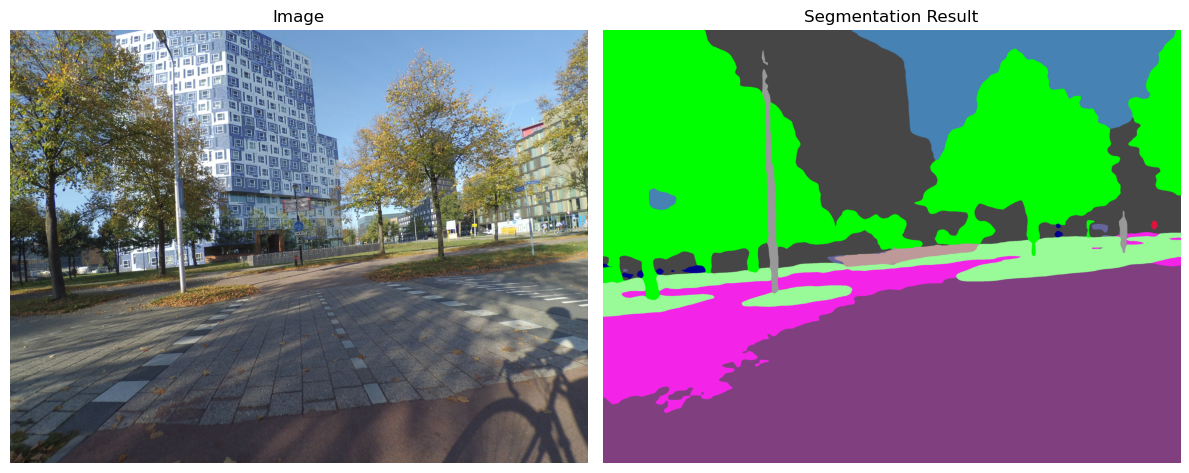

In [19]:
feature_image = features[features.id == 11]
display_images(feature_image)

GVI value: 0.5111807207564398


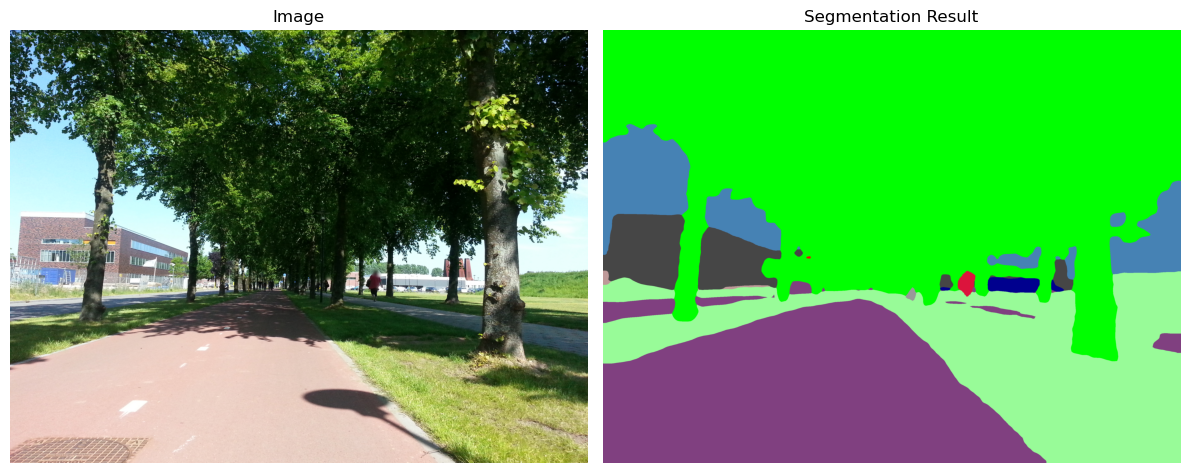

In [20]:
feature_image = features[features.id == 14]
display_images(feature_image)